## packages

In [3]:
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import os,sys

import copy

import h3

import folium

import branca.colormap as cmp

from shapely.geometry import Point, Polygon

import math

import geopandas as gp

import random

import time

import datetime

import scipy.stats as stats

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import gamma

from scipy.stats import poisson

from matplotlib.ticker import PercentFormatter

import seaborn as sns

## UDF

In [4]:
'''Get travel distance'''

def Get_distance(point1,point2):
    
    return Point(point1).distance(Point(point2))*111000*1.2

'''Get travel time'''

def Get_travel_time(dis,speed):
    
    return int(dis/speed)

'''Filter Zones'''

def Get_POLYGON(coords):
    if coords.type=='Polygon':
        return coords
    else:
        Score={i:coords[i].area for i in range(len(coords))}
        idx=max(Score, key=Score.get)
        return coords[idx]
    
'''Randomly Generate nodes'''

def Generate_Point(location,Zone_geometry):
    
    Poly=Zone_geometry[location]
    
    coordinates=list(Poly.exterior.coords)
    
    lngs=[x[0] for x in coordinates]
    
    lats=[x[1] for x in coordinates]
    
    lng_min,lng_max=min(lngs),max(lngs)
    
    lat_min,lat_max=min(lats),max(lats)
    
    lat=random.random()*(lat_max-lat_min)+lat_min
    
    lng=random.random()*(lng_max-lng_min)+lng_min
    
    pnt=Point(lng,lat)
    
    while Poly.contains(pnt)!=True:
        
        lat=random.random()*(lat_max-lat_min)+lat_min
    
        lng=random.random()*(lng_max-lng_min)+lng_min
    
        pnt=Point(lng,lat)
        
    return [lat,lng]

'''Week Transfer'''

def get_week_day(date):
    
    date=datetime.datetime.strptime(date, '%Y-%m-%d')
    
    week_day_dict = {
    0 : 'MON',
    1 : 'TUE',
    2 : 'WED',
    3 : 'THU',
    4 : 'FRI',
    5 : 'SAT',
    6 : 'SUN',
    }
    day = date.weekday()
    
    return week_day_dict[day]

def Get_minute(step):
    
    return int(step/6)

'''Stochastic '''

def Truncated_Gauss(mu,sigma,lower,upper):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return round(X.rvs(1)[0],2)

'''Surging Pricing'''

def Trip_Price(distance,duration,base_fare=2.55,minimum_fare=7):
    
    fare=base_fare+distance*1.75+0.35*duration
    
    fare=max(fare,minimum_fare)
    
    return fare

def Food_Price(distance):
    
    mile=0.621371*distance
    
    return mile*0.6+5.5
        

## param

In [5]:
'''Param'''

resolution = 9



speed=20000/360

Driver_num=3000

'''Path'''

Demand_path='./data/demand/'

Figure_path = './figures/'


'''Load data'''

'''Grid-related data'''

Grid_list=np.load('./Data/NYC_Network/Grids.npy',allow_pickle=True)


'''Point-related data'''

Points_list=np.load('./Data/NYC_Network/Points_list.npy',allow_pickle=True)

Link_Point=np.load('./Data/NYC_Network/Link_Point.npy',allow_pickle=True).item()

Point_coordinate=np.load('./Data/NYC_Network/Point_coordinate.npy',allow_pickle=True).item()

Point_Grid=np.load('./Data/NYC_Network/Point_Grid.npy',allow_pickle=True).item()

''' Dividing NYC to Zones'''

Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data=Zone_data[['borough','zone','geometry','location_i']]

Zone_data=Zone_data.loc[Zone_data['borough']=='Manhattan']

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry','location_i']]

Islands=['Zone_19','Zone_20','Zone_21','Zone_38','Zone_47','Zone_48']

Zone_data=Zone_data.loc[~Zone_data['Zone_id'].isin(Islands)]

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data['geometry']=Zone_data.apply(lambda x:Get_POLYGON(x['geometry']),axis=1)

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data=Zone_data.rename(columns={'location_i':'LocationID'})

Zone_data[['LocationID']] = Zone_data[['LocationID']].astype(float)

Zone_data['type']=Zone_data.apply(lambda x:x['geometry'].type,axis=1)

Zone_geometry={}

for idx,row in Zone_data.iterrows():
    
    Zone_geometry[row['LocationID']]=row['geometry']

Locations=Zone_data['LocationID'].tolist()

# street data

Street_data = gp.read_file('./Data/NYC_Street/geo_export_2d0a9cb9-782e-42c0-ba15-7345a0f64002.shp')

Street_data=Street_data.loc[(Street_data['borocode']=='1')&(Street_data['rw_type'].isin([1,3]))&(Street_data['status']=='2')]

Street_data=Street_data[['st_name','geometry','shape_leng']]

Street_data=Street_data.rename(columns={'shape_leng':'length'})

Street_data['start']=Street_data.apply(lambda x:list(x['geometry'].coords)[0][::-1],axis=1)

Street_data['end']=Street_data.apply(lambda x:list(x['geometry'].coords)[-1][::-1],axis=1)

Street_data['start_grid']=Street_data.apply(lambda x:h3.geo_to_h3(x['start'][0],x['start'][1],resolution),axis=1)

Street_data['end_grid']=Street_data.apply(lambda x:h3.geo_to_h3(x['end'][0],x['end'][1],resolution),axis=1)

Street_data=Street_data.loc[(Street_data['start_grid'].isin(Grid_list))&(Street_data['end_grid'].isin(Grid_list))]
        
Street_data=Street_data.reset_index(drop=True)

Street_data


,st_name,geometry,length,start,end,start_grid,end_grid
0,BENNETT,"LINESTRING (-73.93666 40.85045, -73.93620 40.8...",735.721079,"(40.85044732520501, -73.93666142761384)","(40.852335152313174, -73.93571740885848)",892a100ae77ffff,892a100ae0fffff
1,STONE,"LINESTRING (-74.01007 40.70455, -74.00975 40.7...",122.538700,"(40.704545914131955, -74.01006968341342)","(40.70477524791872, -74.00974639311217)",892a1072817ffff,892a1072817ffff
2,GOLD,"LINESTRING (-74.00684 40.70786, -74.00653 40.7...",159.149459,"(40.707857835737876, -74.0068377870997)","(40.70822712625459, -74.00653116871753)",892a1072887ffff,892a1072887ffff
3,109,"LINESTRING (-73.94969 40.79622, -73.94919 40.7...",508.092565,"(40.79621698487826, -73.94968682996546)","(40.795536417729416, -73.94808516529754)",892a1008d73ffff,892a1008d0fffff
4,AMSTERDAM,"LINESTRING (-73.93192 40.84671, -73.93185 40.8...",38.069869,"(40.8467105236121, -73.93191507377053)","(40.84680263276957, -73.93185010295767)",892a100ae2bffff,892a100ae2bffff
...,...,...,...,...,...,...,...
9598,42,"LINESTRING (-73.99394 40.75898, -73.99547 40.7...",487.040405,"(40.75897926882782, -73.99393650669813)","(40.75962685651496, -73.99547450233167)",892a10725bbffff,892a10725bbffff
9599,HOUSTON,"LINESTRING (-73.98944 40.72308, -73.98879 40.7...",193.415131,"(40.72308392217512, -73.98943880748347)","(40.722893789764065, -73.9887873118406)",892a1072cb3ffff,892a1072cb3ffff
9600,WORTH,"LINESTRING (-74.00211 40.71516, -74.00131 40.7...",260.014217,"(40.71515891016285, -74.00211455770949)","(40.714787443384736, -74.00131368553247)",892a1072c2bffff,892a1072c23ffff
9601,ADAM POWELL,"LINESTRING (-73.93549 40.82673, -73.93533 40.8...",326.475365,"(40.82672573484124, -73.93548534289174)","(40.82759722659591, -73.9353181775285)",892a100abdbffff,892a100abdbffff


## date range

In [6]:
'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/01/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
    if len(Weekdays)>10:
        
        break
        


## spatial visualization

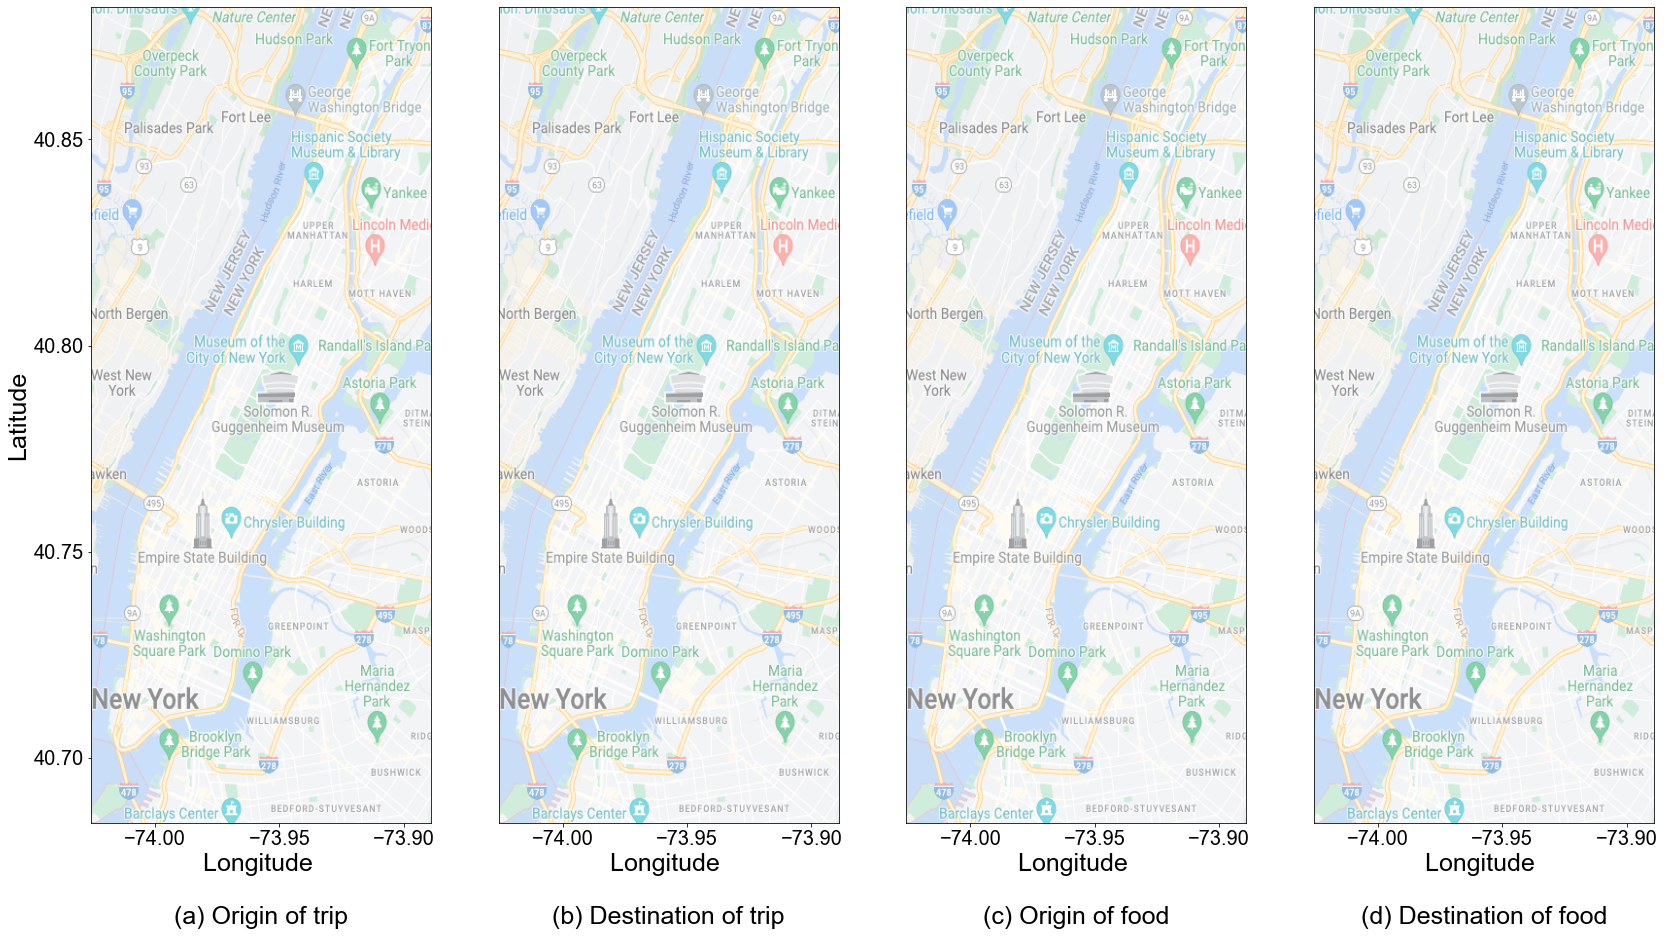

In [7]:
Southwest=[40.684289, -74.025695]

Northeast=[40.882081, -73.889064]

Map_path='./data/map/'

font_title = {'family' : 'Arial','weight' : 'normal','size': 25}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

Titles=['(a) Origin of trip','(b) Destination of trip','(c) Origin of food','(d) Destination of food',]

# Titles=['(a) ','(b) ','(c) ','(d) ']


def Background(area,sw,ne):
    
    bg_path=Map_path+area+'.png'
    
    img = plt.imread(bg_path)
    
    figsize = 28,15
    
    figure, ax1 = plt.subplots(1,4,figsize=figsize)
    
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    
    for i in range(4):

        labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

        [label.set_fontsize(20) for label in labels]

        [label.set_fontname('Arial') for label in labels]

        ax1[i].set_xlim(xgrange)

        ax1[i].set_ylim(ygrange)

        x0,x1 = ax1[i].get_xlim()

        y0,y1 = ax1[i].get_ylim()

        ax1[i].imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)

        ax1[i].set_xlabel('Longitude \n\n'+Titles[i],font_label)

        xmajorLocator   = MultipleLocator(0.05)

        ax1[i].xaxis.set_major_locator(xmajorLocator)

        if i!=0:

            ax1[i].set_yticks([])

        else:

            ax1[i].set_ylabel('Latitude',font_label)

            ymajorLocator1   = MultipleLocator(0.05)

            ax1[i].yaxis.set_major_locator(ymajorLocator1)
       
    
    return figure, ax1

figure, ax1=Background('NYC',Southwest,Northeast)




## Fare distribution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

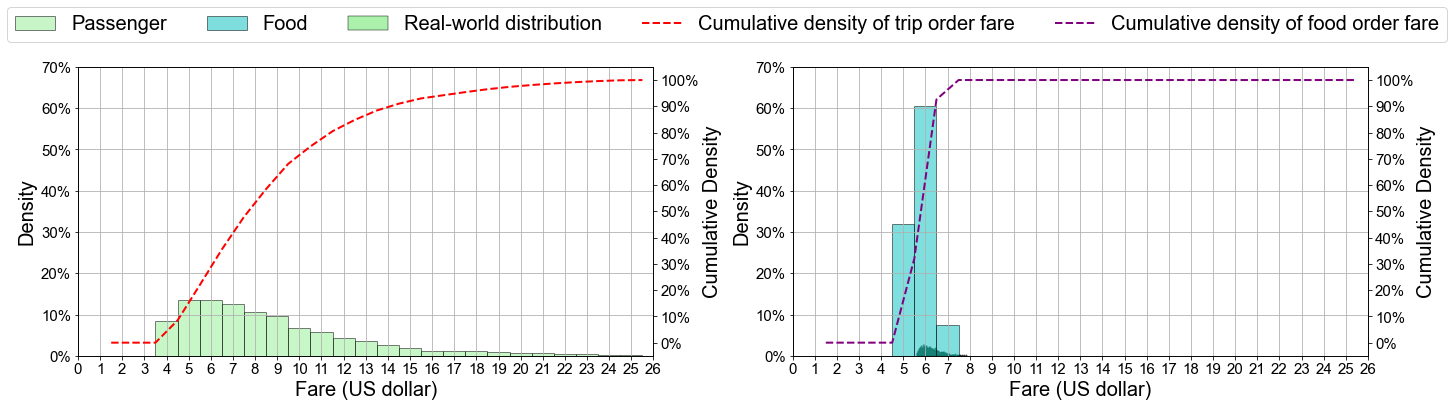

In [10]:
Trip_df=pd.read_csv(os.path.join(Demand_path,'Trip_Order_df_'+str(dt)+'.csv'))

Food_df=pd.read_csv(os.path.join(Demand_path,'Food_Order_df_'+str(dt)+'.csv'))


# 02 histgram

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(1,2,figsize=figsize)
    
for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(15) for label in labels]

    [label.set_fontname('Arial') for label in labels]


trip_fare=np.array(pd.Series(Trip_df['Fare($)']))

trip_fare=trip_fare[(trip_fare<np.quantile(trip_fare, 0.99))&(trip_fare>np.quantile(trip_fare, 0.01))]




Y, X, l1=ax1[0].hist(trip_fare,\
                     bins=range(1,27),\
                       facecolor='lightgreen',\
                       edgecolor='black',\
                       align='left', rwidth=1,
                       histtype='bar',\
                       density=True, \
                       label='Passenger',\
                       alpha=.5)

ax1[0].set_ylabel('Density',font_label)

ax1[0].set_xlabel('Fare (US dollar)',font_label)

xmajorLocator   = MultipleLocator(1)

ax1[0].xaxis.set_major_locator(xmajorLocator)

ax1[0].yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax1[0].grid()


ax2 = ax1[0].twinx()
    
labels = ax2.get_xticklabels() + ax2.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
cumulative = np.cumsum(Y)

c_max=max(cumulative)

step=(X[1]-X[0])/2

l2=ax2.plot([x+step for x in X[:-1]],\
           [round(c/c_max,3) for c in cumulative],\
            color='red',\
            linestyle='--',\
            linewidth=2,\
            label='Cumulative density of trip order fare')

majorLocator   = MultipleLocator(0.1)

ax2.yaxis.set_major_locator(majorLocator) 

ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax2.set_ylabel('Cumulative Density',font_label)

ax1[0].set_ylim([0,.7])

ax1[0].set_xlim([0,26])



food_fare=np.array(pd.Series(Food_df['Fare($)']))

food_fare=food_fare[(food_fare<np.quantile(food_fare, 0.99))&(food_fare>np.quantile(food_fare, 0.01))]

fig1=sns.histplot(food_fare, stat='probability',ax=ax1[1],color='lightgreen',bins=100,label='Real-world distribution')



Y, X, l1=ax1[1].hist(food_fare,\
                     bins=range(1,27),\
                       facecolor='c',\
                       edgecolor='black',\
                       align='left', rwidth=1,
                       histtype='bar',\
                       density=True, \
                       label='Food',\
                       alpha=.5)

ax1[1].set_ylabel('Density',font_label)

ax1[1].set_xlabel('Fare (US dollar)',font_label)

xmajorLocator   = MultipleLocator(1)

ax1[1].xaxis.set_major_locator(xmajorLocator)

ax1[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax1[1].grid()


ax2 = ax1[1].twinx()
    
labels = ax2.get_xticklabels() + ax2.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
cumulative = np.cumsum(Y)

c_max=max(cumulative)

step=(X[1]-X[0])/2

l2=ax2.plot([x+step for x in X[:-1]],\
           [round(c/c_max,3) for c in cumulative],\
            color='purple',\
            linestyle='--',\
            linewidth=2,\
            label='Cumulative density of food order fare')

majorLocator   = MultipleLocator(0.1)

ax2.yaxis.set_major_locator(majorLocator) 

ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))

ax2.set_ylabel('Cumulative Density',font_label)

ax1[1].set_ylim([0,.7])

ax1[1].set_xlim([0,26])


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.15),prop=font_legend,ncol=7)

# show figures

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join(Figure_path,'Fare.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()





## median

In [10]:
fares=np.append(food_fare,trip_fare)

np.quantile(fares, 0.5)



6.5

### Spatial values

In [8]:
def spatila_ratio(df,grid):
    
    stat_df=df.groupby([grid]).count()

    stat_df['grid']=stat_df.index
    
    stat_df['ratio']=(stat_df.Order_id-stat_df.Order_id.min())/(stat_df.Order_id.max()-stat_df.Order_id.min())
    
    return stat_df[['grid','ratio']]

 
order_df=pd.read_csv(os.path.join(Demand_path,'Trip_Order_df_'+str(dt)+'.csv'))

spatila_ratio(order_df,'Pickup_Grid')

Spatial_value={}

for idx,row in spatila_ratio(order_df,'Pickup_Grid').iterrows():
    
    Spatial_value[row.grid]=row.ratio 
    
for grid in Grid_list:
    
    if grid not in Spatial_value.keys():
        
        Spatial_value[grid]=0.0
        
np.save(os.path.join(Demand_path,'Spatial_value.npy'), Spatial_value)